In [1]:
# Dataset: insert URL

import os 
path_to_dataset = "mushroom_dataset"
train_path = path_to_dataset +"/train"
test_path = path_to_dataset + "/test"
valid_path = path_to_dataset + "/valid"


no_of_classes = len(os.listdir(train_path))
print("No. of Classes: " + str(no_of_classes))



No. of Classes: 2


In [2]:

import matplotlib.pyplot as plt
import matplotlib.image as mping
import random

# view a random image
def view_random_image(target_dir, target_class) :
    target_folder = target_dir + "/" + target_class
    # get the random image
    random_image = random.sample(os.listdir(target_folder), 1)
    # show the image
    img = mping.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    plt.show()

    print(f"Image shape: {img.shape}")
    return img

img = view_random_image(target_dir=train_path, target_class='poisonous')

SyntaxError: not a PNG file (<string>)

In [77]:
# Build the model

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Dense
import tensorflow as tf

!pip install torchvision
from torchvision import transforms


In [ ]:

# Image preprocessing

# Data augmentation to generate more data
# Define your augmentation parameters
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,  # Your preprocessing function
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Add a colour jitter
# color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)

#def custom_preprocessing(img):
    """
    Applies InceptionV3 preprocessing, Color Jitter, and standardization.
    """
    #img = tf.keras.applications.inception_v3.preprocess_input(img)
    #img = color_jitter(img)
    #img = (img - img.mean()) / img.std()  # Standardization
    #return img

# Create batches with augmentation for training data
train_batches = datagen.flow_from_directory(
    directory=train_path, 
    target_size=(299,299), 
    classes=['edible', 'poisonous'], 
    batch_size=32)

# For validation and test data, only apply preprocessing (no augmentation)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input) \
    .flow_from_directory(directory=valid_path, 
                         target_size=(299,299), 
                         classes=['edible', 'poisonous'], 
                         batch_size=32)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input) \
    .flow_from_directory(directory=test_path, 
                         target_size=(299,299), 
                         classes=['edible', 'poisonous'], 
                         batch_size=32, 
                         shuffle=False)

Found 3168 images belonging to 2 classes.
Found 792 images belonging to 2 classes.
Found 990 images belonging to 2 classes.


In [13]:
# Visualise the data
imgs, labels = next(train_batches)

# Plotting function to plot the processed images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

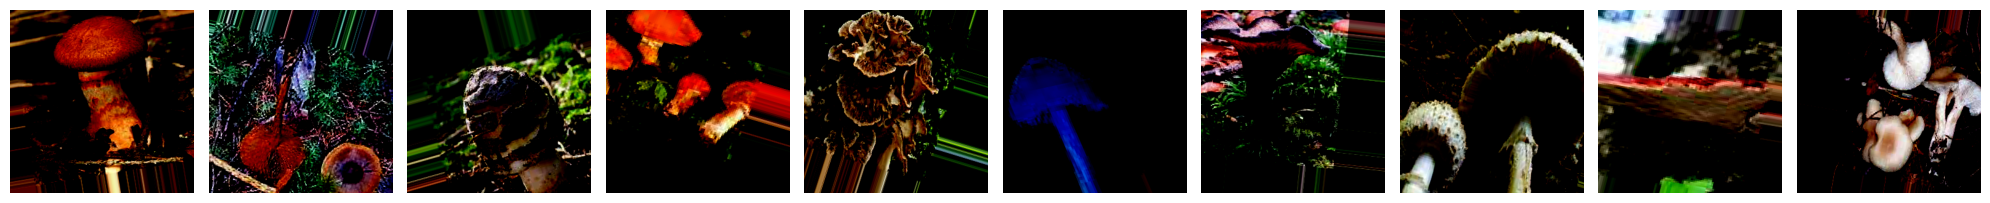

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [14]:
plotImages(imgs)
print(labels)

In [72]:
# create the model
base_model = tf.keras.applications.InceptionV3(include_top=False,              # exclude the top since we are training the model for a new task
    weights="imagenet",
    input_tensor=None,
    input_shape=(299,299,3),                       # there is only edible or poisonous
    classifier_activation="softmax",
    name="incV3_base",
)

# freeze the model
base_model.trainable = False

In [73]:
# Create the inputs into the model
inputs = tf.keras.layers.Input(shape=(299,299,3), name = "input_layer")

In [74]:
# Pass the inputs 
x = base_model(inputs)
print(f"The model shape after passing the inputs: {x.shape}")


The model shape after passing the inputs: (None, 8, 8, 2048)


In [75]:

# Average pool layer the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name = "Global-average-pooling-layer")(x)
print(f"The shape after GlobalAveragePoolid2D: {x.shape}")


The shape after GlobalAveragePoolid2D: (None, 2048)


In [78]:
# Add a Dense layer with trainable parameters
x = Dense(units=64, activation='relu')(x) 

In [79]:
# Add Dropout layer
x = Dropout(rate=0.5)(x)  # Adjust dropout rate as needed

In [80]:

# Create the last output layer
outputs = tf.keras.layers.Dense(no_of_classes, activation='softmax', name='output-layer')(x)


In [81]:

# Merge the inputs and outputs into one model
model = tf.keras.Model(inputs, outputs)


In [61]:
# Lets play with training the model
# Set all layers to non-trainable initially
for layer in model.layers:
    layer.trainable = False

# Make the last 2 layers trainable
for layer in model.layers[-2:]:
    layer.trainable = True

In [82]:

model.compile(loss = "categorical_crossentropy",
              optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics = ["accuracy"])

print(model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ incV3_base (Functional)         │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Global-average-pooling-layer    │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output-layer (Dense)            │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,934,050 (83.67 MB)

 Trainable params: 131,266 (512.76 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

None


In [83]:
EPOCHS = 30

In [84]:
best_model_file = "best_model.keras"

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

callbacks = [
    ModelCheckpoint(best_model_file, verbose=1, save_best_only=True, monitor="val_accuracy"),
    ReduceLROnPlateau(monitor="val_accuracy", patience=4, factor=0.1, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor="val_accuracy", patience=5, verbose=1)
]

In [85]:
# Train the model

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    steps_per_epoch= len(train_batches),
                    validation_data=valid_batches,
                    validation_steps=int(0.25*len(valid_batches)),
                    callbacks=callbacks)

Epoch 1/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.5440 - loss: 0.7302
Epoch 1: val_accuracy improved from -inf to 0.63000, saving model to best_model.keras
317/317 ━━━━━━━━━━━━━━━━━━━━ 163s 500ms/step - accuracy: 0.5441 - loss: 0.7301 - val_accuracy: 0.6300 - val_loss: 0.6308 - learning_rate: 1.0000e-04
Epoch 2/30


c:\Users\colah\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.63000
317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6250 - val_loss: 0.6495 - learning_rate: 1.0000e-04
Epoch 3/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.6376 - loss: 0.6376
Epoch 3: val_accuracy improved from 0.63000 to 0.68500, saving model to best_model.keras
317/317 ━━━━━━━━━━━━━━━━━━━━ 184s 581ms/step - accuracy: 0.6376 - loss: 0.6376 - val_accuracy: 0.6850 - val_loss: 0.6102 - learning_rate: 1.0000e-04
Epoch 4/30

Epoch 4: val_accuracy did not improve from 0.68500
317/317 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6823 - val_loss: 0.6009 - learning_rate: 1.0000e-04
Epoch 5/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 184s 581ms/step - accuracy: 0.6452 - loss: 0.6212 - learning_rate: 1.0000e-04
Epoch 6/30


c:\Users\colah\anaconda3\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
c:\Users\colah\anaconda3\Lib\site-packages\keras\src\callbacks\callback_list.py:151: UserWarning: Learning rate reduction is conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
c:\Users\colah\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss,learning_rate
  current = self.get_monitor_value(logs)



Epoch 6: val_accuracy did not improve from 0.68500
317/317 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6800 - val_loss: 0.5952 - learning_rate: 1.0000e-04
Epoch 7/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.6606 - loss: 0.6110
Epoch 7: val_accuracy did not improve from 0.68500
317/317 ━━━━━━━━━━━━━━━━━━━━ 196s 618ms/step - accuracy: 0.6606 - loss: 0.6110 - val_accuracy: 0.6650 - val_loss: 0.5884 - learning_rate: 1.0000e-04
Epoch 8/30

Epoch 8: val_accuracy did not improve from 0.68500

Epoch 8: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
317/317 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6800 - val_loss: 0.6052 - learning_rate: 1.0000e-04
Epoch 9/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.6778 - loss: 0.5951
Epoch 9: val_accuracy did not improve from 0.68500
317/317 ━━━━━━━━━━━━━━━━━━━━ 175s 552ms/step - accuracy: 0.6778 - loss:

In [86]:
# evaluate the test data

print(model.evaluate(test_batches))


99/99 ━━━━━━━━━━━━━━━━━━━━ 34s 340ms/step - accuracy: 0.6616 - loss: 0.5970
[0.576535701751709, 0.7030302882194519]


In [87]:
print(len(history.history["loss"]))
print(len(history.history["val_loss"]))
print(len(history.history["accuracy"]))
print(len(history.history["val_accuracy"]))

9
8
9
8


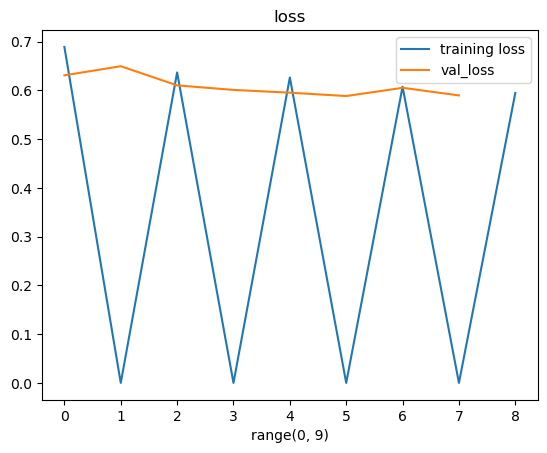

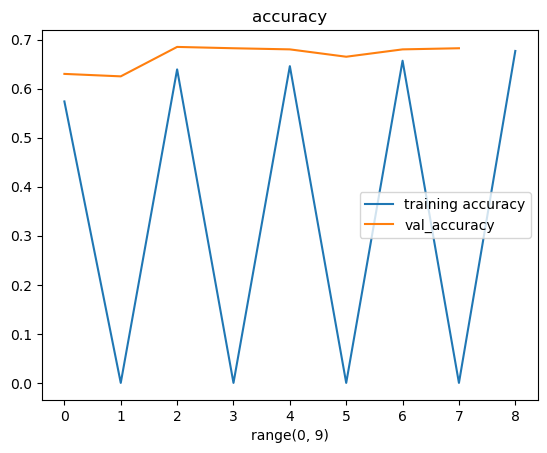

In [88]:

# plot the results

def plot_loss_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))
    epochs_val = range(len(history.history["val_loss"]))

    # plot the loss
    plt.plot(epochs, loss, label = "training loss")
    plt.plot(epochs_val, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel(epochs)
    plt.legend()
    plt.show()

      # plot the accuracy
    plt.plot(epochs, accuracy, label = "training accuracy")
    plt.plot(epochs_val, val_accuracy, label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel(epochs)
    plt.legend()
    plt.show()

# run the function
plot_loss_curves(history)


